In [21]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os
import csv
from tqdm import tqdm
import pandas as pd

import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions

import torch
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import random_split


In [22]:
output_dir = os.path.join(".", "output_front_ppo")  # Path to the output directory
subdirs = [f.path for f in os.scandir(output_dir) if f.is_dir()]
subdirs.sort()

# Create an empty 3D array to store the combined data
combined_arr_f = np.empty((len(subdirs), 1000, 10))

# Loop through each subdirectory and load the CSV files
for i, subdir in enumerate(subdirs):
    action_filename = os.path.join(subdir, "action.csv")
    obs_filename = os.path.join(subdir, "obs.csv")

    # Load the action and obs CSV files
    action_df = pd.read_csv(action_filename,  header=None)
    obs_df = pd.read_csv(obs_filename,  header=None)

    # Concatenate the DataFrames horizontally
    combined_data = pd.concat([action_df, obs_df], axis=1)

    # Convert combined_data to a 3D array and assign it to combined_arr
    combined_arr_f[i-1] = np.reshape(combined_data.values, (1000, 10))

# Print the shape of combined_arr
print(combined_arr_f.shape)
combined_tensor_f = torch.from_numpy(combined_arr_f)

(10000, 1000, 10)


In [23]:
output_dir = os.path.join(".", "output_bw_sac")  # Path to the output directory
subdirs = [f.path for f in os.scandir(output_dir) if f.is_dir()]
subdirs.sort()

# Create an empty 3D array to store the combined data
combined_arr_b = np.empty((len(subdirs), 1000, 10))

# Loop through each subdirectory and load the CSV files
for i, subdir in enumerate(subdirs):
    action_filename = os.path.join(subdir, "action.csv")
    obs_filename = os.path.join(subdir, "obs.csv")

    # Load the action and obs CSV files
    action_df = pd.read_csv(action_filename,  header=None)
    obs_df = pd.read_csv(obs_filename,  header=None)

    # Concatenate the DataFrames horizontally
    combined_data = pd.concat([action_df, obs_df], axis=1)

    # Convert combined_data to a 3D array and assign it to combined_arr
    combined_arr_b[i-1] = np.reshape(combined_data.values, (1000, 10))

# Print the shape of combined_arr
print(combined_arr_b.shape)
combined_tensor_b = torch.from_numpy(combined_arr_b)

(10000, 1000, 10)


In [24]:
output_dir = os.path.join(".", "output_right_ppo")  # Path to the output directory
subdirs = [f.path for f in os.scandir(output_dir) if f.is_dir()]
subdirs.sort()

# Create an empty 3D array to store the combined data
combined_arr_r = np.empty((len(subdirs), 1000, 10))

# Loop through each subdirectory and load the CSV files
for i, subdir in enumerate(subdirs):
    action_filename = os.path.join(subdir, "action.csv")
    obs_filename = os.path.join(subdir, "obs.csv")

    # Load the action and obs CSV files
    action_df = pd.read_csv(action_filename,  header=None)
    obs_df = pd.read_csv(obs_filename,  header=None)

    # Concatenate the DataFrames horizontally
    combined_data = pd.concat([action_df, obs_df], axis=1)

    # Convert combined_data to a 3D array and assign it to combined_arr
    combined_arr_r[i-1] = np.reshape(combined_data.values, (1000, 10))

# Print the shape of combined_arr
print(combined_arr_r.shape)
combined_tensor_r = torch.from_numpy(combined_arr_r)

(10000, 1000, 10)


In [25]:
output_dir = os.path.join(".", "output_jelly")  # Path to the output directory
subdirs = [f.path for f in os.scandir(output_dir) if f.is_dir()]
subdirs.sort()

# Create an empty 3D array to store the combined data
combined_arr_j = np.empty((len(subdirs), 1000, 10))

# Loop through each subdirectory and load the CSV files
for i, subdir in enumerate(subdirs):
    action_filename = os.path.join(subdir, "action.csv")
    obs_filename = os.path.join(subdir, "obs.csv")

    # Load the action and obs CSV files
    action_df = pd.read_csv(action_filename,  header=None)
    obs_df = pd.read_csv(obs_filename,  header=None)

    # Concatenate the DataFrames horizontally
    combined_data = pd.concat([action_df, obs_df], axis=1)

    # Convert combined_data to a 3D array and assign it to combined_arr
    combined_arr_j[i-1] = np.reshape(combined_data.values, (1000, 10))

# Print the shape of combined_arr
print(combined_arr_j.shape)
combined_tensor_j = torch.from_numpy(combined_arr_j)

(10000, 1000, 10)


# VAE code -1

In [26]:
class Encoder(nn.Module):
    def __init__(self, input_shape, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_shape, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim3),
            nn.ReLU(),
            nn.Linear(hidden_dim3, latent_dim * 2)  # mean and variance
        )

    def forward(self, x):
        h = self.encoder(x)
        mu, log_var = h.chunk(2, dim=1)
        return mu, log_var, h


class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_shape):
        super(Decoder, self).__init__()

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim3),
            nn.ReLU(),
            nn.Linear(hidden_dim3, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, output_shape),
        )

    def forward(self, z):
        x_reconstructed = self.decoder(z)
        return x_reconstructed


class VAE(nn.Module):
    def __init__(self, input_shape, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim):
        super(VAE, self).__init__()

        self.encoder = Encoder(input_shape, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim1, hidden_dim2, hidden_dim3, input_shape)

    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var / 2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var, h = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mu, log_var

In [27]:
# Assuming combined_tensor is your data
# Convert the data to float32
datasetf = TensorDataset(combined_tensor_f.float())
datasetb = TensorDataset(combined_tensor_b.float())
datasetr = TensorDataset(combined_tensor_r.float())
datasetj = TensorDataset(combined_tensor_j.float())
# Define the data loader
batch_size = 512  # adjust as necessary
 
del combined_tensor_f
del combined_tensor_b
del combined_tensor_r
# del combined_tensor_j

In [28]:
# Split data into train, validation, and test
ftrain_size = int(0.7 * len(datasetf))  # 70% for training
fvalid_size = int(0.15 * len(datasetf))  # 15% for validation
ftest_size = len(datasetf) - ftrain_size - fvalid_size  # 15% for testing

ftrain_dataset, fvalid_dataset, ftest_dataset = random_split(datasetf, [ftrain_size, fvalid_size, ftest_size])

ftrain_loader = DataLoader(ftrain_dataset, batch_size=batch_size, shuffle=True)
fvalid_loader = DataLoader(fvalid_dataset, batch_size=batch_size, shuffle=True)
ftest_loader = DataLoader(ftest_dataset, batch_size=batch_size, shuffle=True)


In [29]:
# Split data into train, validation, and test
btrain_size = int(0.7 * len(datasetb))  # 70% for training
bvalid_size = int(0.15 * len(datasetb))  # 15% for validation
btest_size = len(datasetb) - btrain_size - bvalid_size  # 15% for testing

btrain_dataset, bvalid_dataset, btest_dataset = random_split(datasetb, [btrain_size, bvalid_size, btest_size])

btrain_loader = DataLoader(btrain_dataset, batch_size=batch_size, shuffle=True)
bvalid_loader = DataLoader(bvalid_dataset, batch_size=batch_size, shuffle=True)
btest_loader = DataLoader(btest_dataset, batch_size=batch_size, shuffle=True)


In [30]:
# Split data into train, validation, and test
rtrain_size = int(0.7 * len(datasetr))  # 70% for training
rvalid_size = int(0.15 * len(datasetr))  # 15% for validation
rtest_size = len(datasetr) - rtrain_size - rvalid_size  # 15% for testing

rtrain_dataset, rvalid_dataset, rtest_dataset = random_split(datasetr, [rtrain_size, rvalid_size, rtest_size])

rtrain_loader = DataLoader(rtrain_dataset, batch_size=batch_size, shuffle=True)
rvalid_loader = DataLoader(rvalid_dataset, batch_size=batch_size, shuffle=True)
rtest_loader = DataLoader(rtest_dataset, batch_size=batch_size, shuffle=True)


In [31]:
# Split data into train, validation, and test
jtrain_size = int(0.7 * len(datasetj))  # 70% for training
jvalid_size = int(0.15 * len(datasetj))  # 15% for validation
jtest_size = len(datasetj) - jtrain_size - jvalid_size  # 15% for testing

jtrain_dataset, jvalid_dataset, jtest_dataset = random_split(datasetj, [jtrain_size, jvalid_size, jtest_size])

jtrain_loader = DataLoader(jtrain_dataset, batch_size=batch_size, shuffle=True)
jvalid_loader = DataLoader(jvalid_dataset, batch_size=batch_size, shuffle=True)
jtest_loader = DataLoader(jtest_dataset, batch_size=batch_size, shuffle=True)


# 여기서부터

In [61]:
# Hyperparameters
# input_shape = combined_tensor.shape[1] * combined_tensor.shape[2]  # modify this to match your data
# hidden_dim1 = 128  # modify as needed
# hidden_dim2 = 64  # modify as needed
# hidden_dim3 = 24  # modify as needed
# latent_dim = 2  # modify as needed
# lr = 5e-5  # learning rate
# n_epochs = 200  # modify as needed
# beta = 0.2
input_shape = combined_tensor_j.shape[1] * combined_tensor_j.shape[2]  # modify this to match your data
hidden_dim1 = 24  # modify as needed
hidden_dim2 = 12  # modify as needed
hidden_dim3 = 12  # modify as needed
latent_dim = 2  # modify as needed
lr = 5e-5  # learning rate
n_epochs = 200  # modify as needed
beta = 0.2
    

# Model, optimizer, and loss function
model = VAE(input_shape, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim)

optimizer = optim.RAdam(model.parameters(), lr=lr)  # Make sure you're using the correct optimizer
loss_fn = nn.MSELoss()  # And the correct loss function


def train(epoch, model, optimizer, loss_fn, train_loader):
    model.train()
    train_loss = 0
    total_recon_loss = 0
    total_kl_div = 0
    for i, batch in enumerate(train_loader):  # using train_loader instead of dataloader
        batch_data = batch[0]  # get the data from the batch
        
        optimizer.zero_grad()

        # Flatten the data
        batch_data = batch_data.view(batch_data.size(0), -1)

        reconstructed_batch, mu, log_var = model(batch_data)

        # Loss: reconstruction loss + KL divergence
        recon_loss = loss_fn(reconstructed_batch, batch_data)
        kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = recon_loss + beta*kl_divergence

        loss.backward()
        train_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_kl_div += kl_divergence.item()
        optimizer.step()

    avg_loss = train_loss / len(train_loader.dataset)
    avg_recon_loss = total_recon_loss / len(train_loader.dataset)
    avg_kl_div = total_kl_div / len(train_loader.dataset)
#     print(f'====> Epoch: {epoch} Average loss: {avg_loss}, Recon Loss: {avg_recon_loss}, KL Div: {avg_kl_div}')

    return avg_loss, avg_recon_loss, avg_kl_div


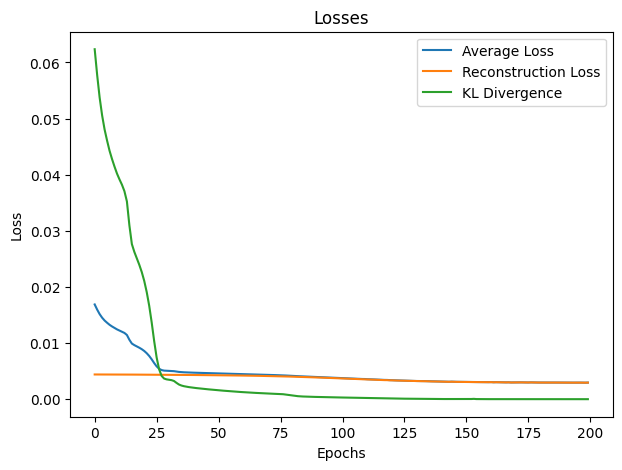

In [62]:
import matplotlib.pyplot as plt

# Lists to store losses for each epoch
bavg_losses = []
bavg_recon_losses = []
bavg_kl_divs = []

# Training
for epoch in range(1, n_epochs + 1):
    bavg_loss, bavg_recon_loss, bavg_kl_div = train(epoch, model, optimizer, loss_fn, btrain_loader)
    bavg_losses.append(bavg_loss)
    bavg_recon_losses.append(bavg_recon_loss)
    bavg_kl_divs.append(bavg_kl_div)

# Plot the losses
plt.figure(figsize=(7,5))
plt.plot(bavg_losses, label='Average Loss')
plt.plot(bavg_recon_losses, label='Reconstruction Loss')
plt.plot(bavg_kl_divs, label='KL Divergence')
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


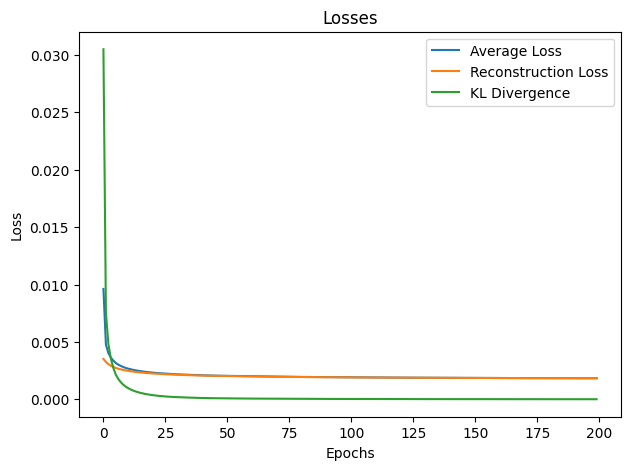

In [63]:
import matplotlib.pyplot as plt

# Lists to store losses for each epoch
javg_losses = []
javg_recon_losses = []
javg_kl_divs = []

# Training
for epoch in range(1, n_epochs + 1):
    javg_loss, javg_recon_loss, javg_kl_div = train(epoch, model, optimizer, loss_fn, jtrain_loader)
    javg_losses.append(javg_loss)
    javg_recon_losses.append(javg_recon_loss)
    javg_kl_divs.append(javg_kl_div)

# Plot the losses
plt.figure(figsize=(7,5))
plt.plot(javg_losses, label='Average Loss')
plt.plot(javg_recon_losses, label='Reconstruction Loss')
plt.plot(javg_kl_divs, label='KL Divergence')
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


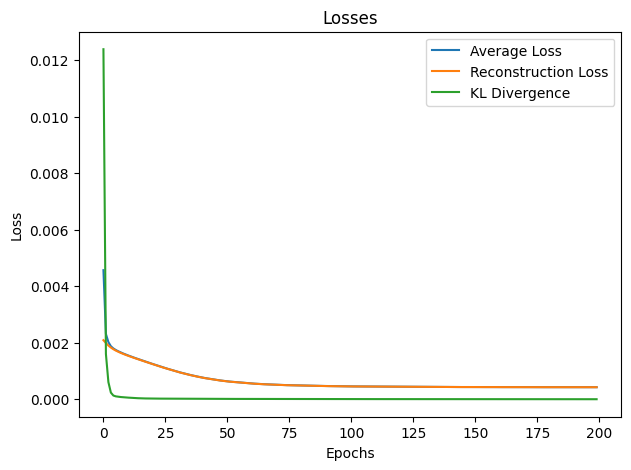

In [64]:
import matplotlib.pyplot as plt

# Lists to store losses for each epoch
ravg_losses = []
ravg_recon_losses = []
ravg_kl_divs = []

# Training
for epoch in range(1, n_epochs + 1):
    ravg_loss, ravg_recon_loss, ravg_kl_div = train(epoch, model, optimizer, loss_fn, rtrain_loader)
    ravg_losses.append(ravg_loss)
    ravg_recon_losses.append(ravg_recon_loss)
    ravg_kl_divs.append(ravg_kl_div)

# Plot the losses
plt.figure(figsize=(7,5))
plt.plot(ravg_losses, label='Average Loss')
plt.plot(ravg_recon_losses, label='Reconstruction Loss')
plt.plot(ravg_kl_divs, label='KL Divergence')
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


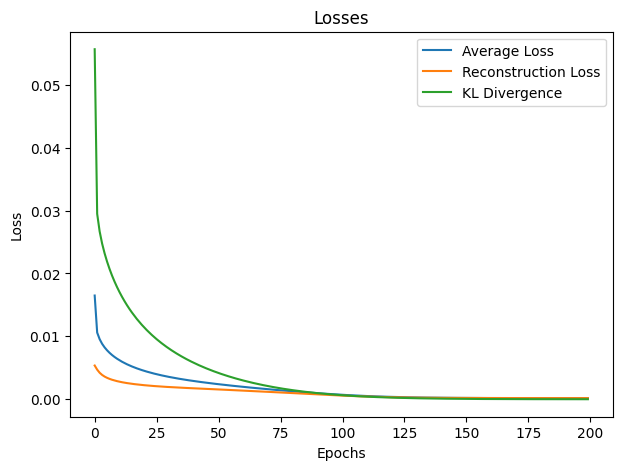

In [65]:
import matplotlib.pyplot as plt

# Lists to store losses for each epoch
favg_losses = []
favg_recon_losses = []
favg_kl_divs = []

# Training
for epoch in range(1, n_epochs + 1):
    favg_loss, favg_recon_loss, favg_kl_div = train(epoch, model, optimizer, loss_fn, ftrain_loader)
    favg_losses.append(favg_loss)
    favg_recon_losses.append(favg_recon_loss)
    favg_kl_divs.append(favg_kl_div)

# Plot the losses
plt.figure(figsize=(7,5))
plt.plot(favg_losses, label='Average Loss')
plt.plot(favg_recon_losses, label='Reconstruction Loss')
plt.plot(favg_kl_divs, label='KL Divergence')
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# latent space plot

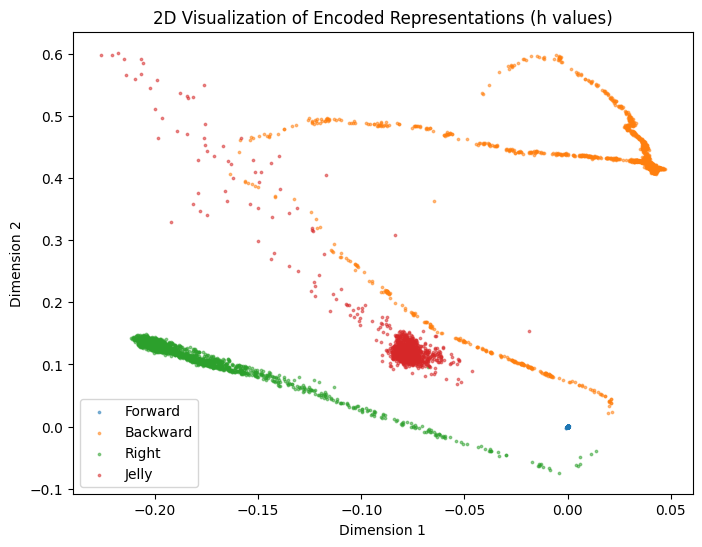

In [66]:
# Get encoded representations (h values) for all data points
encoded_representations_forward = []
encoded_representations_backward = []
encoded_representations_right = []
encoded_representations_jelly = []
model.eval()
with torch.no_grad():
    for batch in ftest_loader:
        batch_data = batch[0]
        batch_data = batch_data.view(batch_data.size(0), -1)
        batch_data = batch_data.float()
        _, _, h = model.encoder(batch_data)  # Get the encoded representation (h value) directly
        encoded_representations_forward.append(h)

encoded_representations_forward = torch.cat(encoded_representations_forward, dim=0).numpy()

with torch.no_grad():
    for batch in btest_loader:
        batch_data = batch[0]
        batch_data = batch_data.view(batch_data.size(0), -1)
        batch_data = batch_data.float()
        _, _, h = model.encoder(batch_data)  # Get the encoded representation (h value) directly
        encoded_representations_backward.append(h)
        
encoded_representations_backward = torch.cat(encoded_representations_backward, dim=0).numpy()

with torch.no_grad():
    for batch in rtest_loader:
        batch_data = batch[0]
        batch_data = batch_data.view(batch_data.size(0), -1)
        batch_data = batch_data.float()
        _, _, h = model.encoder(batch_data)  # Get the encoded representation (h value) directly
        encoded_representations_right.append(h)
        
encoded_representations_right = torch.cat(encoded_representations_right, dim=0).numpy()

with torch.no_grad():
    for batch in jtest_loader:
        batch_data = batch[0]
        batch_data = batch_data.view(batch_data.size(0), -1)
        batch_data = batch_data.float()
        _, _, h = model.encoder(batch_data)  # Get the encoded representation (h value) directly
        encoded_representations_jelly.append(h)

encoded_representations_jelly = torch.cat(encoded_representations_jelly, dim=0).numpy()

# # Assuming the encoded representations are 2D, plot the data in 2D space
# plt.figure(figsize=(8, 6))
# plt.scatter(encoded_representations[:, 0], encoded_representations[:, 1], alpha=0.5, s=3)
# plt.xlabel('Dimension 1')
# plt.ylabel('Dimension 2')
# plt.title('2D Visualization of Encoded Representations (h values)')
# plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(encoded_representations_forward[:, 0], encoded_representations_forward[:, 1], alpha=0.5, s=3, label='Forward')
plt.scatter(encoded_representations_backward[:, 0], encoded_representations_backward[:, 1], alpha=0.5, s=3, label='Backward')
plt.scatter(encoded_representations_right[:, 0], encoded_representations_right[:, 1], alpha=0.5, s=3, label='Right')
plt.scatter(encoded_representations_jelly[:, 0], encoded_representations_jelly[:, 1], alpha=0.5, s=3, label='Jelly')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D Visualization of Encoded Representations (h values)')
plt.legend()
plt.show()


# save the model

In [67]:
# model_save_path = f'vae_model_favg_losses_{favg_losses[-1]:.4f}.pth'
# torch.save(model.state_dict(), model_save_path)
# print(f"Model saved to {model_save_path}")

# Load model

In [68]:
# # Load the model
# loaded_model = VAE(input_shape, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim)
# loaded_model.load_state_dict(torch.load(model_save_path))
# loaded_model.eval()


In [76]:
from collections import defaultdict
import pandas as pd

def test_model(model, jtest_loader):
    model.eval()
    
    # 각 레이블에 대한 원본 및 재구성 데이터 프레임을 저장합니다.
    original_dfs = defaultdict(list)
    reconstructed_dfs = defaultdict(list)

    with torch.no_grad():
        for i, (batch_data, batch_labels) in enumerate(jtest_loader):
            batch_data = batch_data.view(batch_data.size(0), -1)
            batch_data = batch_data.float()
            reconstructed_batch, _, _ = model(batch_data)

            original_data = batch_data.detach().cpu().numpy()
            reconstructed_data = reconstructed_batch.detach().cpu().numpy()
            labels = batch_labels.detach().cpu().numpy()

            # 각 레이블에 대해 데이터 프레임을 생성하고 저장합니다.
            for label, orig, recon in zip(labels, original_data, reconstructed_data):
                original_dfs[label].append(pd.DataFrame(orig.reshape(1, -1)))
                reconstructed_dfs[label].append(pd.DataFrame(recon.reshape(1, -1)))

    # 각 레이블의 데이터 프레임을 연결합니다.
    for label in original_dfs.keys():
        original_dfs[label] = pd.concat(original_dfs[label])
        reconstructed_dfs[label] = pd.concat(reconstructed_dfs[label])

    return original_dfs, reconstructed_dfs

# 훈련 후 함수를 호출합니다.
original_dfs, reconstructed_dfs = test_model(model, jtest_loader)

# 예를 들어 레이블 1에 대한 원본 및 재구성된 데이터를 가져옵니다.
label1_original_df = original_dfs[3]
label1_reconstructed_df = reconstructed_dfs[3]


ori_combined_np = label1_original_df.to_numpy()
recon_combined_np = label1_reconstructed_df.to_numpy()

# Column names
column_names = ['action space : Torque applied on the first rotor', 
                'action space : Torque applied on the second rotor', 
                'obs0', 'obs1', 'obs2', 'obs3', 'obs4', 'obs5', 'obs6', 'obs7']

# Create a figure
plt.figure(figsize=(20, 20))

# Create subplots for each column

for i in range(10):  # Assuming you have 10 columns
    plt.subplot(5, 2, i+1)  # 5 rows and 2 columns of subplots
    plt.scatter(ori_combined_np[i, :], recon_combined_np[i, :], alpha=0.5, s=5)
    plt.title(column_names[i])
    plt.xlabel('Original')
    plt.ylabel('Reconstructed')

# Display the plot
plt.tight_layout()
plt.show()


ValueError: not enough values to unpack (expected 2, got 1)